# BAX 423 Big Data Final Project - Steam Game Platform Recommendation System

## Colab pyspark environment set up

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop3.2.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop3.2.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop3.2"

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# spark
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as F
from pyspark.sql.functions import concat, col, lit, when, max, lower
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import *

# nlp 
from pyspark.sql.functions import explode,regexp_extract,regexp_replace
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
from pyspark.ml.feature import Word2Vec
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import CountVectorizer
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.ml.feature import NGram

# topics modeling
from pyspark.ml.clustering import LDA

from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

In [0]:
# initialise sparkContext
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('steam') \
                    .config('spark.executor.memory', '10gb') \
                    .config("spark.cores.max", "6") \
                    .getOrCreate()

## Load dataset 

In [0]:
# user-review data
Reviews = spark.read.csv("/content/drive/My Drive/steam/final dataset/raw_reviews.csv", 
                         inferSchema = True, header = True, sep=';')    #mode="DROPMALFORMED"
print(Reviews.count())
Reviews.show(5)

1817436
+------+-----------------+--------+-------------+---------------+--------+--------------------+-------------------+--------+--------------------+-------------------+-----------+-------+---------+------------------+------------+-------------+----------+
|GameID|          SteamID|ReviewID|NumGamesOwned|NumReviewsGiven|PlayTime|PlayTimeLastTwoWeeks|       LastPlayTime|Language|              Review|        TimeCreated|Recommended|VotesUp|VoteFunny| WeightedVoteScore|CommentCount|SteamPurchase|WriteEarly|
+------+-----------------+--------+-------------+---------------+--------+--------------------+-------------------+--------+--------------------+-------------------+-----------+-------+---------+------------------+------------+-------------+----------+
|925340|76561198200016459|62850082|          307|             13|     192|                   0|2020-02-02 03:00:43| english|Yuu is a student ...|2020-02-02 03:03:18|          1|      7|        0|0.6070303916931151|           0|      

In [0]:
# game data
Games = spark.read.csv("/content/drive/My Drive/steam/final dataset/df_games.csv", 
                       inferSchema = True, header = True, sep=';')
print(Games.count())
Games.show(5)

7808
+------+--------------------------+-----+--------------------+--------------------+--------------------+--------------------+------------+------------+------+--------------------+-----+----+---------------+----------------+
| AppID|                   AppName|Genre|                Tags|           Developer|           Publisher|         ReviewInfor|ReviewStatus| ReleaseDate|IsFree|               Price|month|year|ReviewSentiment|        NewGenre|
+------+--------------------------+-----+--------------------+--------------------+--------------------+--------------------+------------+------------+------+--------------------+-----+----+---------------+----------------+
|925340|       A Winter's Daydream|Indie|['Indie', 'Simula...|            ebi-hime|            ebi-hime|Positive(19)- 100...|        true|Oct 15, 2018| false|{'currency': 'USD...|  Oct|2018|       Positive|      Simulation|
|925440|神社的百合香 ~ Floral A...|Indie|['Indie', 'RPG', ...|            凝冰剑斩|            凝冰剑斩|Very Posi

In [0]:
# join review and game data in one table
t1 = Reviews.alias('t1')
t2 = Games.alias('t2')

steam = t1.join(Games, t1.GameID==t2.AppID, 'inner') \
        .select(t1["*"],t2["AppName"],t2["NewGenre"],t2["Developer"],t2["ReviewSentiment"])

steam.show(5)

+------+-----------------+--------+-------------+---------------+--------+--------------------+-------------------+--------+--------------------+-------------------+-----------+-------+---------+------------------+------------+-------------+----------+-------------------+----------+---------+---------------+
|GameID|          SteamID|ReviewID|NumGamesOwned|NumReviewsGiven|PlayTime|PlayTimeLastTwoWeeks|       LastPlayTime|Language|              Review|        TimeCreated|Recommended|VotesUp|VoteFunny| WeightedVoteScore|CommentCount|SteamPurchase|WriteEarly|            AppName|  NewGenre|Developer|ReviewSentiment|
+------+-----------------+--------+-------------+---------------+--------+--------------------+-------------------+--------+--------------------+-------------------+-----------+-------+---------+------------------+------------+-------------+----------+-------------------+----------+---------+---------------+
|925340|76561198200016459|62850082|          307|             13|     

In [0]:
Games.printSchema()

root
 |-- AppID: integer (nullable = true)
 |-- AppName: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Developer: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- ReviewInfor: string (nullable = true)
 |-- ReviewStatus: string (nullable = true)
 |-- ReleaseDate: string (nullable = true)
 |-- IsFree: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- ReviewSentiment: string (nullable = true)
 |-- NewGenre: string (nullable = true)



In [0]:
steam.printSchema()

root
 |-- GameID: integer (nullable = true)
 |-- SteamID: long (nullable = true)
 |-- ReviewID: integer (nullable = true)
 |-- NumGamesOwned: integer (nullable = true)
 |-- NumReviewsGiven: integer (nullable = true)
 |-- PlayTime: integer (nullable = true)
 |-- PlayTimeLastTwoWeeks: integer (nullable = true)
 |-- LastPlayTime: timestamp (nullable = true)
 |-- Language: string (nullable = true)
 |-- Review: string (nullable = true)
 |-- TimeCreated: string (nullable = true)
 |-- Recommended: string (nullable = true)
 |-- VotesUp: string (nullable = true)
 |-- VoteFunny: string (nullable = true)
 |-- WeightedVoteScore: string (nullable = true)
 |-- CommentCount: string (nullable = true)
 |-- SteamPurchase: string (nullable = true)
 |-- WriteEarly: string (nullable = true)
 |-- AppName: string (nullable = true)
 |-- NewGenre: string (nullable = true)
 |-- Developer: string (nullable = true)
 |-- ReviewSentiment: string (nullable = true)



## Data preprocessing 

In [0]:
#Reviews.where(F.isnull(F.col("Review"))).show()
steam.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in steam.columns]).show()

+------+-------+--------+-------------+---------------+--------+--------------------+------------+--------+------+-----------+-----------+-------+---------+-----------------+------------+-------------+----------+-------+--------+---------+---------------+
|GameID|SteamID|ReviewID|NumGamesOwned|NumReviewsGiven|PlayTime|PlayTimeLastTwoWeeks|LastPlayTime|Language|Review|TimeCreated|Recommended|VotesUp|VoteFunny|WeightedVoteScore|CommentCount|SteamPurchase|WriteEarly|AppName|NewGenre|Developer|ReviewSentiment|
+------+-------+--------+-------------+---------------+--------+--------------------+------------+--------+------+-----------+-----------+-------+---------+-----------------+------------+-------------+----------+-------+--------+---------+---------------+
|     0|      0|       0|            0|              0|       0|                   0|           0|       0|   441|         24|         23|     40|       41|               43|          44|           44|        44|      0|       0|   

In [0]:
# drop rows with null reviews 
df_reviews_nonull = steam.filter(steam.Review.isNotNull() & steam.TimeCreated.isNotNull() & steam.Recommended.isNotNull())

In [0]:
# convert "Review" column to lower case
df_reviews_nonull = df_reviews_nonull.withColumn("Review", lower(col("Review")))
df_reviews_nonull.show(5)

+------+-----------------+--------+-------------+---------------+--------+--------------------+-------------------+--------+--------------------+-------------------+-----------+-------+---------+------------------+------------+-------------+----------+-------------------+----------+---------+---------------+
|GameID|          SteamID|ReviewID|NumGamesOwned|NumReviewsGiven|PlayTime|PlayTimeLastTwoWeeks|       LastPlayTime|Language|              Review|        TimeCreated|Recommended|VotesUp|VoteFunny| WeightedVoteScore|CommentCount|SteamPurchase|WriteEarly|            AppName|  NewGenre|Developer|ReviewSentiment|
+------+-----------------+--------+-------------+---------------+--------+--------------------+-------------------+--------+--------------------+-------------------+-----------+-------+---------+------------------+------------+-------------+----------+-------------------+----------+---------+---------------+
|925340|76561198200016459|62850082|          307|             13|     

In [0]:
# add index for better filtering
steam_reviewnonull = df_reviews_nonull.withColumn('index', monotonically_increasing_id())
steam_reviewnonull.createOrReplaceTempView("steam_reviewnonull")
steam_reviewnonull.show(5)

+------+-----------------+--------+-------------+---------------+--------+--------------------+-------------------+--------+--------------------+-------------------+-----------+-------+---------+------------------+------------+-------------+----------+-------------------+----------+---------+---------------+-----+
|GameID|          SteamID|ReviewID|NumGamesOwned|NumReviewsGiven|PlayTime|PlayTimeLastTwoWeeks|       LastPlayTime|Language|              Review|        TimeCreated|Recommended|VotesUp|VoteFunny| WeightedVoteScore|CommentCount|SteamPurchase|WriteEarly|            AppName|  NewGenre|Developer|ReviewSentiment|index|
+------+-----------------+--------+-------------+---------------+--------+--------------------+-------------------+--------+--------------------+-------------------+-----------+-------+---------+------------------+------------+-------------+----------+-------------------+----------+---------+---------------+-----+
|925340|76561198200016459|62850082|          307|   

In [0]:
#remove numbers
from pyspark.sql.functions import explode,regexp_extract,regexp_replace
review_nonum = steam_reviewnonull.withColumn('nonnum', F.regexp_replace(F.col('Review'),'\d+',''))

# remove urls
review_nourlnum = review_nonum.withColumn('nonurl',F.regexp_replace(F.col('nonnum'),'^https?:\/\/.*[\r\n]*',''))

# remove bbwords: [*]
review_regclean = review_nourlnum.withColumn('regclean',F.regexp_replace(F.col('nonurl'),'(\\[\w+])',''))

review_regclean.select('index', 'SteamID', 'Review', 'regclean').show(15)

+-----+-----------------+--------------------+--------------------+
|index|          SteamID|              Review|            regclean|
+-----+-----------------+--------------------+--------------------+
|    0|76561198200016459|yuu is a student ...|yuu is a student ...|
|    1|76561198080360383|a short, but (bit...|a short, but (bit...|
|    2|76561198412449978|welll this vn was...|welll this vn was...|
|    3|76561198130402546|a vn with a short...|a vn with a short...|
|    4|76561198136886006|a young man from ...|a young man from ...|
|    5|76561198201193771|i really didnt ex...|i really didnt ex...|
|    6|76561198306329717|the biggest pity ...|the biggest pity ...|
|    7|76561198044179216|i really enjoyed ...|i really enjoyed ...|
|    8|76561198909074195|i really liked th...|i really liked th...|
|    9|76561198069159152|this is an intere...|this is an intere...|
|   10|76561198413350620|[i]family is like...|family is like mu...|
|   11|76561198035898856|"8/10. minimal pr...|"/

In [0]:
# handle negation
no_nt_review = review_regclean.withColumn('modified_negation1',regexp_replace(F.col('regclean'),r"n't",r' not'))
no_nt_review = no_nt_review.withColumn('modified_negation2', 
                   regexp_replace(F.col('modified_negation1'),r'not ',r'not_'))
no_nt_review.select('index', 'SteamID', 'modified_negation1').show(15)

+-----+-----------------+--------------------+
|index|          SteamID|  modified_negation1|
+-----+-----------------+--------------------+
|    0|76561198200016459|yuu is a student ...|
|    1|76561198080360383|a short, but (bit...|
|    2|76561198412449978|welll this vn was...|
|    3|76561198130402546|a vn with a short...|
|    4|76561198136886006|a young man from ...|
|    5|76561198201193771|i really didnt ex...|
|    6|76561198306329717|the biggest pity ...|
|    7|76561198044179216|i really enjoyed ...|
|    8|76561198909074195|i really liked th...|
|    9|76561198069159152|this is an intere...|
|   10|76561198413350620|family is like mu...|
|   11|76561198035898856|"/. minimal prese...|
|   12|76561198065148936|a really involved...|
|   13|76561197999540711|a very engaging s...|
|   14|76561197994048123|a winter's dream ...|
+-----+-----------------+--------------------+
only showing top 15 rows



In [0]:
# remove punctuation
cleaned_review = no_nt_review.withColumn('nopunct', 
                        F.regexp_replace(F.col('modified_negation2'),'[^\w\s]',''))

cleaned_review.select('index', 'SteamID', 'nopunct').show(15)

+-----+-----------------+--------------------+
|index|          SteamID|             nopunct|
+-----+-----------------+--------------------+
|    0|76561198200016459|yuu is a student ...|
|    1|76561198080360383|a short but bitte...|
|    2|76561198412449978|welll this vn was...|
|    3|76561198130402546|a vn with a short...|
|    4|76561198136886006|a young man from ...|
|    5|76561198201193771|i really didnt ex...|
|    6|76561198306329717|the biggest pity ...|
|    7|76561198044179216|i really enjoyed ...|
|    8|76561198909074195|i really liked th...|
|    9|76561198069159152|this is an intere...|
|   10|76561198413350620|family is like mu...|
|   11|76561198035898856| minimal presenta...|
|   12|76561198065148936|a really involved...|
|   13|76561197999540711|a very engaging s...|
|   14|76561197994048123|a winters dream i...|
+-----+-----------------+--------------------+
only showing top 15 rows



In [0]:
# tokenizing
tokenizer = Tokenizer(inputCol = 'nopunct', outputCol = 'review_token')

df_token = tokenizer.transform(cleaned_review)
df_token.select('index', 'Review','review_token').show(5)

+-----+--------------------+--------------------+
|index|              Review|        review_token|
+-----+--------------------+--------------------+
|    0|yuu is a student ...|[yuu, is, a, stud...|
|    1|a short, but (bit...|[a, short, but, b...|
|    2|welll this vn was...|[welll, this, vn,...|
|    3|a vn with a short...|[a, vn, with, a, ...|
|    4|a young man from ...|[a, young, man, f...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [0]:
# remove stop words
locale = spark._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

stopwordList = ["game", "games", "play","", "really", "like","liked", "pretty", "ever", 
                "played", "though", "get", "got", "one", "yes", "sure", "im", "there",
                "still", "not_sure", "id", "overall", "much", "oh", "seem", "lot",
                "ive", "let", "your", "also", "yet", "wo", "may", "actual", "want", "might",
                "us", "_", "nope", "um", "h", "e", "o", "feel", "well", "done"]

stopwordList.extend(StopWordsRemover().getStopWords())

stopwords = StopWordsRemover(inputCol = 'review_token', outputCol = 'stopwords_removed', stopWords=stopwordList)
df_stopwords = stopwords.transform(df_token)
df_stopwords.select('index', 'Review', 'review_token', 'stopwords_removed').show(5)

+-----+--------------------+--------------------+--------------------+
|index|              Review|        review_token|   stopwords_removed|
+-----+--------------------+--------------------+--------------------+
|    0|yuu is a student ...|[yuu, is, a, stud...|[yuu, student, at...|
|    1|a short, but (bit...|[a, short, but, b...|[short, bitterswe...|
|    2|welll this vn was...|[welll, this, vn,...|[welll, vn, somet...|
|    3|a vn with a short...|[a, vn, with, a, ...|[vn, short, sweet...|
|    4|a young man from ...|[a, young, man, f...|[young, man, rura...|
+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [0]:
# stem text
stemmer = SnowballStemmer(language='english')
stemmer_udf = F.udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
df_stemmed = df_stopwords.withColumn("words_stemmed", stemmer_udf("stopwords_removed"))
df_stemmed.select("index", "Review", 'stopwords_removed', "words_stemmed").show(10)

+-----+--------------------+--------------------+--------------------+
|index|              Review|   stopwords_removed|       words_stemmed|
+-----+--------------------+--------------------+--------------------+
|    0|yuu is a student ...|[yuu, student, at...|[yuu, student, at...|
|    1|a short, but (bit...|[short, bitterswe...|[short, bitterswe...|
|    2|welll this vn was...|[welll, vn, somet...|[welll, vn, somet...|
|    3|a vn with a short...|[vn, short, sweet...|[vn, short, sweet...|
|    4|a young man from ...|[young, man, rura...|[young, man, rura...|
|    5|i really didnt ex...|[didnt, expect, v...|[didnt, expect, v...|
|    6|the biggest pity ...|[biggest, pity, c...|[biggest, piti, c...|
|    7|i really enjoyed ...|[enjoyed, not_hel...|[enjoy, not_help,...|
|    8|i really liked th...|[novel, visual, e...|[novel, visual, e...|
|    9|this is an intere...|[interesting, kin...|[interest, kinet,...|
+-----+--------------------+--------------------+--------------------+
only s

In [0]:
# bi-gram feature extraction
ngram = NGram(n=2, inputCol="words_stemmed", outputCol="ngrams")
ngramDataFrame = ngram.transform(df_stemmed)
ngramDataFrame.select(col("index"), col("words_stemmed"), col("ngrams")).show(10)

+-----+--------------------+--------------------+
|index|       words_stemmed|              ngrams|
+-----+--------------------+--------------------+
|    0|[yuu, student, at...|[yuu student, stu...|
|    1|[short, bitterswe...|[short bitterswee...|
|    2|[welll, vn, somet...|[welll vn, vn som...|
|    3|[vn, short, sweet...|[vn short, short ...|
|    4|[young, man, rura...|[young man, man r...|
|    5|[didnt, expect, v...|[didnt expect, ex...|
|    6|[biggest, piti, c...|[biggest piti, pi...|
|    7|[enjoy, not_help,...|[enjoy not_help, ...|
|    8|[novel, visual, e...|[novel visual, vi...|
|    9|[interest, kinet,...|[interest kinet, ...|
+-----+--------------------+--------------------+
only showing top 10 rows



In [0]:
w2v = Word2Vec(vectorSize= 100, inputCol = 'words_stemmed', outputCol ='w2v_vectors', minCount = 10)
model_word2vec = w2v.fit(df_stemmed)
w2v_result = model_word2vec.transform(ngramDataFrame)
w2v_result.show(15)

In [0]:
w2v_dict = model_word2vec.getVectors()
w2v_dict.show(15)

+--------------------+--------------------+
|                word|              vector|
+--------------------+--------------------+
|             maebara|[0.14522261917591...|
|               dredd|[-0.6350565552711...|
|              gaiden|[-1.1797527074813...|
|             zoetrop|[0.00658221216872...|
|              hanabi|[-0.0792886391282...|
|            incident|[0.13368627429008...|
|urlhttpsstorestea...|[0.10916520655155...|
|            accostum|[-0.0553653426468...|
|        spoilerabout|[0.01201893761754...|
|       meteorologist|[0.23989403247833...|
|              zauber|[-0.2865073084831...|
|             serious|[-0.0282031968235...|
|            sevenday|[-0.0510169863700...|
|               brink|[-0.1404587924480...|
|            igavania|[-0.1137246266007...|
|         misadventur|[-0.0365433655679...|
|             acronym|[0.00284376367926...|
|           foolproof|[0.05134603753685...|
|           everchang|[0.10885650664567...|
|          ghostpedia|[0.0182510

In [0]:
w2v_dict.toPandas().to_csv('content/drive/My Drive/steam/final dataset/w2v_dict.csv', index=False)
model_word2vec.save("content/drive/My Drive/steam/final dataset/word2vec.model")
#model_word2vec = Word2Vec.load("word2vec.model")

In [0]:
# # tf-idf
# hashingTF = HashingTF(inputCol="words_stemmed", outputCol="tf", numFeatures=20)
# tf = hashingTF.transform(ngramDataFrame)
# # alternatively, CountVectorizer can also be used to get term frequency vectors

# idf = IDF(inputCol="tf", outputCol="tfidf_features")
# idfModel = idf.fit(tf)
# tfidf = idfModel.transform(tf)

# tfidf.select("index", "tfidf_features").show()

## Topics modelling 

In [0]:
# count the appearing frequeny of each bi-gram token in reviews
cv = CountVectorizer(inputCol="ngrams", outputCol="features", minDF=3)
model = cv.fit(ngramDataFrame)
vocabArray = model.vocabulary

result = model.transform(ngramDataFrame).select('index','features').cache()
#train, test = result.randomSplit([0.7, 0.3], 1)

In [0]:
vocabArray

['voic act',
 'high recommend',
 'super hot',
 'earli access',
 'hot super',
 'art style',
 'look forward',
 'combat system',
 'star war',
 'long time',
 'point click',
 'full price',
 'good stori',
 'great stori',
 'first time',
 'turn base',
 'come back',
 'littl bit',
 'go back',
 'recommend anyon',
 'replay valu',
 'everi time',
 'ca not_wait',
 'definit worth',
 'level design',
 'singl player',
 'old school',
 'boss fight',
 'main charact',
 'worth money',
 'worth price',
 'your look',
 'definit recommend',
 'superhot superhot',
 'year ago',
 'open world',
 'stori line',
 'look good',
 'stori good',
 'buffalo buffalo',
 'even better',
 'make sens',
 'take time',
 'good thing',
 'side quest',
 'interest stori',
 'negat review',
 'dark soul',
 'give tri',
 'great fun',
 'everi singl',
 'baldur gate',
 'ca not_recommend',
 'fast pace',
 'stori great',
 'fun littl',
 'worth buy',
 'sound effect',
 'good time',
 'main stori',
 'real life',
 'wast time',
 'year old',
 'banner saga',
 'm

In [0]:
# train the LDA model 
lda = LDA(k=6, maxIter=50, optimizer="online", seed=1)
ldaModel = lda.fit(result)

#print("The lower bound on the log likelihood of the entire corpus: ", ldaModel.logLikelihood(t))
#print("The LDA model perplexity is: ", ldaModel.logPerplexity(train))

In [0]:
# print out topics and their representative words 
topics_rdd = ldaModel.describeTopics().rdd

topics_words = topics_rdd\
       .map(lambda row: row['termIndices'])\
       .map(lambda idx_list: [vocabArray[idx] for idx in idx_list])\
       .collect()

for idx, topic in enumerate(topics_words):
    print("topic: ", idx)
    print("----------")
    for word in topic:
        print(word)
    print()

topic:  0
----------
voic act
high recommend
great stori
art style
good stori
combat system
turn base
stori line
grim dawn
stori great

topic:  1
----------
superhot superhot
click click
boss fight
bind isaac
level design
final boss
high recommend
full price
dungeon crawler
random generat

topic:  2
----------
super hot
hot super
buffalo buffalo
refund pls
pls refund
super fun
bring back
fun love
real life
simpl fun

topic:  3
----------
everi time
look forward
go back
first time
long time
negat review
year ago
make sens
your look
full price

topic:  4
----------
earli access
ca not_wait
old school
fun fun
high recommend
current state
singl player
saint row
fun friend
great fun

topic:  5
----------
star war
point click
voic act
main charact
high recommend
dark soul
replay valu
singl player
visual novel
click adventur



In [0]:
# describe token indices and their corresponding weights for each topic
descr_tokens = ldaModel.describeTopics(6)
print("The topics described by their top-weighted terms:")
descr_tokens.show()

The topics described by their top-weighted terms:
+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[0, 1, 13, 5, 12, 7]|[0.00401656896922...|
|    1|[33, 76, 27, 143,...|[0.00214187138153...|
|    2|[2, 4, 39, 130, 1...|[0.03227361250021...|
|    3|[21, 6, 18, 14, 9...|[8.58657188602857...|
|    4|[3, 22, 26, 294, ...|[0.00783392561797...|
|    5|[8, 10, 0, 28, 1,...|[0.00319606998399...|
+-----+--------------------+--------------------+



In [0]:
# show features and topic distribution
transformed = ldaModel.transform(result)
transformed.show(5)

+-----+--------------------+--------------------+
|index|            features|   topicDistribution|
+-----+--------------------+--------------------+
|    0|(262144,[16,28,34...|[0.00253660232210...|
|    1|(262144,[2711,938...|[0.01445863320441...|
|    2|(262144,[18,3830,...|[0.00720170988581...|
|    3|(262144,[442,2212...|[0.31404956855702...|
|    4|(262144,[669,1724...|[0.00527301082674...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [0]:
# explode topics
def ith_(v, i):
    try:
        return float(v[i])
    except ValueError:
        return None

ith = F.udf(ith_, DoubleType())

tpc_pivot_tbl = transformed.select(["index"] + [ith("topicDistribution", 
                                        F.lit(i)).alias('topic_'+str(i)) for i in range(6)] )
tpc_pivot_tbl.show(10)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|             topic_0|             topic_1|             topic_2|             topic_3|             topic_4|             topic_5|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|0.002536602322103...|0.002223641168001272|0.001741923118296...|  0.2490151854649642|0.002153020632249445|  0.7423296272943843|
|    1|0.014458633204412603|0.012698214123566828| 0.00994798998716764|   0.937844360266083|0.012289071355584644|0.012761731063185412|
|    2|0.007201709885817856|0.006300643318596739|  0.3018729712827112| 0.32170950315882907|0.006101702728088852|  0.3568134696259564|
|    3| 0.31404956855702654| 0.01072096583193198|0.008397106661656452|0.012044558892135881|0.010365163373076216|  0.6444226366841729|
|    4|0.005273010826740236| 0.00460710625856307|0.00361028743

In [0]:
tpc_pivot_tbl.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/tpc_pivot.csv", index=False)

In [0]:
tpc_pivot_tbl = spark.read.csv("/content/drive/My Drive/steam/Jun4th analysis/tpc_pivot.csv", inferSchema = True, header = True) 
tpc_pivot_tbl.show(5)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|             topic_0|             topic_1|             topic_2|             topic_3|             topic_4|             topic_5|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|0.002536602322103...|0.002223641168001272|0.001741923118296...|  0.2490151854649642|0.002153020632249445|  0.7423296272943843|
|    1|0.014458633204412603|0.012698214123566828| 0.00994798998716764|   0.937844360266083|0.012289071355584644|0.012761731063185412|
|    2|0.007201709885817856|0.006300643318596739|  0.3018729712827112| 0.32170950315882907|0.006101702728088852|  0.3568134696259564|
|    3| 0.31404956855702654| 0.01072096583193198|0.008397106661656452|0.012044558892135881|0.010365163373076216|  0.6444226366841729|
|    4|0.005273010826740236| 0.00460710625856307|0.00361028743

In [0]:
from pyspark.sql.functions import col, lit, coalesce, greatest

# find the max topic weights for each document
minf = lit(float("-inf"))
rowmax = greatest(*[coalesce(col(x), minf) for x in ['topic_0','topic_1','topic_2', 'topic_3', 'topic_4', "topic_5"]])
doc_tpc = tpc_pivot_tbl.withColumn("max_weight", rowmax)

# find the topic index of highest topic weights
cond = "F.when" + ".when".join(["(F.col('" + c + "') == F.col('max_weight'), F.lit('" + c + "'))" \
                                for c in doc_tpc.columns])

doc_tpc = doc_tpc.withColumn("TopicIndex", eval(cond)).select("index", "max_weight", "TopicIndex")
doc_tpc.show()

+-----+------------------+----------+
|index|        max_weight|TopicIndex|
+-----+------------------+----------+
|    0|0.7423296272943843|   topic_5|
|    1| 0.937844360266083|   topic_3|
|    2|0.3568134696259564|   topic_5|
|    3|0.6444226366841729|   topic_5|
|    4| 0.976821900908151|   topic_5|
|    5|0.7232521090744111|   topic_5|
|    6|0.7558403633126842|   topic_5|
|    7|0.7129846122386959|   topic_5|
|    8|  0.74149287212105|   topic_0|
|    9|0.8814523330241976|   topic_5|
|   10|0.6309066271972209|   topic_5|
|   11|0.6799751129513201|   topic_5|
|   12|0.9317450312750118|   topic_0|
|   13|0.9417347602900547|   topic_5|
|   14| 0.966859238522062|   topic_5|
|   15|0.6130306275607669|   topic_5|
|   16|0.9633382527764783|   topic_5|
|   17|0.9241496710646364|   topic_5|
|   18|0.9547848114389372|   topic_0|
|   19|0.6389070250469109|   topic_0|
+-----+------------------+----------+
only showing top 20 rows



Topics Identified

Topic 0: Game story and UI/UX </br>
keywords such as ‘great storyline’ and ‘voice act’ appear under topic with relatively higher weight.</br></br>

Topic 1: Game strategy </br>
keywords such as ‘final boss’ and ‘click’, which might be users discussing specific game strategies.</br></br>

Topic 2: Sentiment expression </br>
users express their feelings toward certain games which can be either positive, like ‘simple fun’ or show their disappointment such as ‘pls refund’.</br></br>

Topic 3: Performance & stability </br>
keywords such as ‘bug’ and ‘long time’ suggest that this topic is about games’ performance and stability.</br></br>

Topic 4: Tactics </br> 
there are tactical gameplay keywords such as ‘early access’.</br></br>

Topic 5: Game character & content </br>
keywords such as ‘dark soul’ and ‘main character’ cluster reviews under topic 6 game characters and content. 

## User Segmentation

### Step 1: All users information

In [0]:
# join ngramDataFrame and doc_tpc by index
t1 = ngramDataFrame.alias('t1')
t2 = doc_tpc.alias('t2')

df_full = t1.join(t2, t1.index==t2.index, 'inner').select(t1["*"], t2["max_weight"], t2["TopicIndex"])
df_full.printSchema()

root
 |-- GameID: integer (nullable = true)
 |-- SteamID: long (nullable = true)
 |-- ReviewID: integer (nullable = true)
 |-- NumGamesOwned: integer (nullable = true)
 |-- NumReviewsGiven: integer (nullable = true)
 |-- PlayTime: integer (nullable = true)
 |-- PlayTimeLastTwoWeeks: integer (nullable = true)
 |-- LastPlayTime: string (nullable = true)
 |-- Language: string (nullable = true)
 |-- Review: string (nullable = true)
 |-- TimeCreated: string (nullable = true)
 |-- Recommended: string (nullable = true)
 |-- VotesUp: string (nullable = true)
 |-- VoteFunny: string (nullable = true)
 |-- WeightedVoteScore: string (nullable = true)
 |-- CommentCount: string (nullable = true)
 |-- SteamPurchase: string (nullable = true)
 |-- WriteEarly: string (nullable = true)
 |-- AppName: string (nullable = true)
 |-- NewGenre: string (nullable = true)
 |-- Developer: string (nullable = true)
 |-- ReviewSentiment: string (nullable = true)
 |-- index: long (nullable = false)
 |-- nonnum: string

In [0]:
# correct data types (Recommended, VotesUp, VoteFunny, WeightedVoteScore: string to float; 
#                     LastPlayTime and TimeCreated to timestamp)

df_user = df_full.select("index", "SteamID", "NumGamesOwned", "NumReviewsGiven", "PlayTime", "LastPlayTime",
                         "PlayTimeLastTwoWeeks", "Recommended", "VotesUp", "VoteFunny", "TimeCreated", 
                         "WeightedVoteScore", "GameID", "NewGenre", "TopicIndex")

df_user = df_user.select("index", "SteamID", "NumGamesOwned", "NumReviewsGiven", "PlayTime", 
                         "PlayTimeLastTwoWeeks","GameID", "NewGenre", "TopicIndex",
                          df_user.LastPlayTime.cast("timestamp").alias("LastPlayTime"),
                          df_user.TimeCreated.cast("timestamp").alias("TimeCreated"),
                          df_user.Recommended.cast('int').alias('Recommended'),
                          df_user.VotesUp.cast('int').alias('VotesUp'), 
                          df_user.VoteFunny.cast('int').alias('VoteFunny'), 
                          df_user.WeightedVoteScore.cast('double').alias('WeightedVoteScore')
                          )

df_user.createOrReplaceTempView("df_user")
df_user.printSchema()

root
 |-- index: long (nullable = false)
 |-- SteamID: long (nullable = true)
 |-- NumGamesOwned: integer (nullable = true)
 |-- NumReviewsGiven: integer (nullable = true)
 |-- PlayTime: integer (nullable = true)
 |-- PlayTimeLastTwoWeeks: integer (nullable = true)
 |-- GameID: integer (nullable = true)
 |-- NewGenre: string (nullable = true)
 |-- TopicIndex: string (nullable = true)
 |-- LastPlayTime: timestamp (nullable = true)
 |-- TimeCreated: timestamp (nullable = true)
 |-- Recommended: integer (nullable = true)
 |-- VotesUp: integer (nullable = true)
 |-- VoteFunny: integer (nullable = true)
 |-- WeightedVoteScore: double (nullable = true)



In [0]:
# find each user's first LastPlayTime record and calculate day gaps between other later LastPlayTimes and the first date
days_tbl = spark.sql("select distinct *, datediff(LastPlayTime, \
                first_value(LastPlayTime) over (partition by SteamID order by LastPlayTime)) as days, \
                min(LastPlayTime) over (partition by SteamID) as first_review, \
                max(PlayTimeLastTwoWeeks) over (partition by SteamID, GameID) as max_PlayTimeLastTwoWeeks \
                from df_user")

days_tbl.createOrReplaceTempView("days_tbl")
days_tbl.show(10)

+-----------+-----------------+-------------+---------------+--------+--------------------+------+----------------+----------+-------------------+-------------------+-----------+-------+---------+------------------+-----+-------------------+------------------------+
|      index|          SteamID|NumGamesOwned|NumReviewsGiven|PlayTime|PlayTimeLastTwoWeeks|GameID|        NewGenre|TopicIndex|       LastPlayTime|        TimeCreated|Recommended|VotesUp|VoteFunny| WeightedVoteScore| days|       first_review|max_PlayTimeLastTwoWeeks|
+-----------+-----------------+-------------+---------------+--------+--------------------+------+----------------+----------+-------------------+-------------------+-----------+-------+---------+------------------+-----+-------------------+------------------------+
|      18428|76561197960269579|          430|             34|     249|                   0|372350|Action-Adventure|   topic_1|2017-06-07 14:00:56|2016-06-03 20:44:15|          1|      4|        2|0.5

#### Step 1.1 Create static user profile

In [0]:
# To avoid duplications, for each user's each reviewed game id, only keep the max days (last review time) and max playtime

game_aggregation_tbl = spark.sql("select distinct SteamID, NumGamesOwned, NumReviewsGiven, \
                 GameID, Recommended, NewGenre, TopicIndex, \
                 max(PlayTime) over (partition by SteamID, GameID) as GamePlayTime, \
                 max(days) over (partition by SteamID, GameID) as max_days \
            from days_tbl")

game_aggregation_tbl.createOrReplaceTempView("game_aggregation_tbl")
game_aggregation_tbl.show(10)

+-----------------+-------------+---------------+------+-----------+----------------+----------+------------+--------+
|          SteamID|NumGamesOwned|NumReviewsGiven|GameID|Recommended|        NewGenre|TopicIndex|GamePlayTime|max_days|
+-----------------+-------------+---------------+------+-----------+----------------+----------+------------+--------+
|76561197960269579|          430|             34|372350|          1|Action-Adventure|   topic_1|         249|       0|
|76561197960269579|          430|             34|396750|          1|Action-Adventure|   topic_4|        1265|     263|
|76561197960269579|          430|             34|666140|          1|             RPG|   topic_0|        3377|     957|
|76561197960272407|         1851|             25| 31290|          1|Action-Adventure|   topic_5|         158|   15320|
|76561197960272407|         1852|             25|205630|          1|      Simulation|   topic_3|           0|       0|
|76561197960272423|          412|             16

In [0]:
# create user's genre profiles: group by user and genre, calculate the percentage of playtime for each genre
# PlayTimePercent = (user's playtime spent on this genre of games) / (total playtime by this user)
# for example, user A spent 50% time in playing Action-Adventure games, 50% on RPG, and 0 on simulation, 
#then user A's profile will be 50% Action-Adventure, 50% RPG and 0% Simulation

genre_aggregation_tbl = spark.sql("select SteamID, NumGamesOwned, NumReviewsGiven, NewGenre, \
                                    round(sum(GamePlayTime)/sum(sum(GamePlayTime)) \
                                            over (partition by SteamID), 3) as PlayTimePercent\
                                   from game_aggregation_tbl \
                                   group by SteamID, NumGamesOwned, NumReviewsGiven, NewGenre ")

genre_pivot = genre_aggregation_tbl.groupby(col("SteamID"), col("NumGamesOwned"), col("NumReviewsGiven"))\
                .pivot("NewGenre").max("PlayTimePercent").na.fill(0)

genre_pivot.show(10)

+-----------------+-------------+---------------+----------------+-----+----------+
|          SteamID|NumGamesOwned|NumReviewsGiven|Action-Adventure|  RPG|Simulation|
+-----------------+-------------+---------------+----------------+-----+----------+
|76561197960269579|          430|             34|            0.31| 0.69|       0.0|
|76561197960272407|         1851|             25|             1.0|  0.0|       0.0|
|76561197960272407|         1852|             25|             0.0|  0.0|       0.0|
|76561197960272423|          412|             16|             0.0|  0.0|       1.0|
|76561197960272973|          391|              6|             0.0|  0.0|       1.0|
|76561197960274794|          746|              5|           0.057|0.943|       0.0|
|76561197960275854|          240|              7|             1.0|  0.0|       0.0|
|76561197960286046|          522|             12|             1.0|  0.0|       0.0|
|76561197960344050|          565|             21|             1.0|  0.0|    

In [0]:
# create user's review topic profiles: group by user and major topic index, calculate TopicPercent
# TopicPercent = (number of times that reviews within this topic) / (total review times)
# for example, if user A gave 3 reviews in total, 1 time about topic_0, 1 time about topic_1 
#and 1 time about topic_4, then userA's profile will be 33% topic_0, 33% topic_1, and 33% topic_4

tpc_aggregation_tbl = spark.sql("select SteamID, NumGamesOwned, NumReviewsGiven, TopicIndex, \
                                    round(count(*)/sum(count(*)) \
                                            over (partition by SteamID), 3) as TopicPercent\
                                 from game_aggregation_tbl \
                                 group by SteamID, NumGamesOwned, NumReviewsGiven, TopicIndex ")

tpc_pivot = tpc_aggregation_tbl.groupby(col("SteamID"), col("NumGamesOwned"), col("NumReviewsGiven"))\
                .pivot("TopicIndex").max("TopicPercent").na.fill(0)

tpc_pivot.show(10)

+-----------------+-------------+---------------+-------+-------+-------+-------+-------+-------+
|          SteamID|NumGamesOwned|NumReviewsGiven|topic_0|topic_1|topic_2|topic_3|topic_4|topic_5|
+-----------------+-------------+---------------+-------+-------+-------+-------+-------+-------+
|76561197960269579|          430|             34|  0.333|  0.333|    0.0|    0.0|  0.333|    0.0|
|76561197960272407|         1851|             25|    0.0|    0.0|    0.0|    0.0|    0.0|    0.5|
|76561197960272407|         1852|             25|    0.0|    0.0|    0.0|    0.5|    0.0|    0.0|
|76561197960272423|          412|             16|    0.5|    0.0|    0.0|    0.0|    0.5|    0.0|
|76561197960272973|          391|              6|    0.0|    0.0|    0.0|    1.0|    0.0|    0.0|
|76561197960274794|          746|              5|    0.0|    0.0|    0.0|    0.5|    0.5|    0.0|
|76561197960275854|          240|              7|    0.0|    0.0|    0.0|    1.0|    0.0|    0.0|
|76561197960286046| 

In [0]:
# create user's recommended percent and age proxy profile
# RecommendedPercent = (recommended times) / (user's total review times)
# SteamAgeProxy = (last play time - first appearing last play time) / 7 --> possible weeks stayed with Steam

days_sentiment_agg_tbl = spark.sql("select distinct SteamID, NumGamesOwned, NumReviewsGiven, \
                                         round(sum(Recommended)/count(Recommended), 3) as RecommendedPercent, \
                                         round(max(max_days)/7,0) as SteamAgeProxy \
                                    from game_aggregation_tbl \
                                    group by SteamID, NumGamesOwned, NumReviewsGiven")

days_sentiment_agg_tbl.show(10)

+-----------------+-------------+---------------+------------------+-------------+
|          SteamID|NumGamesOwned|NumReviewsGiven|RecommendedPercent|SteamAgeProxy|
+-----------------+-------------+---------------+------------------+-------------+
|76561197960269579|          430|             34|               1.0|        137.0|
|76561197960272407|         1851|             25|               1.0|       2189.0|
|76561197960272407|         1852|             25|               1.0|          0.0|
|76561197960272423|          412|             16|               1.0|         26.0|
|76561197960272973|          391|              6|               1.0|          0.0|
|76561197960274794|          746|              5|               0.5|        227.0|
|76561197960275854|          240|              7|               0.0|          0.0|
|76561197960286046|          522|             12|               1.0|          0.0|
|76561197960344050|          565|             21|             0.667|        145.0|
|765

In [0]:
# join user's genre, topic, and recommended & age profiles in one table

t1 = genre_pivot.alias('t1')
t2 = days_sentiment_agg_tbl.alias('t2')
t3 = tpc_pivot.alias('t3')

user_profile = t1.join(t2, (t1.SteamID==t2.SteamID) & (t1.NumGamesOwned==t2.NumGamesOwned) \
                & (t1.NumReviewsGiven==t2.NumReviewsGiven), 'inner') \
                .join(t3,  (t1.SteamID==t3.SteamID) & (t1.NumGamesOwned==t3.NumGamesOwned) \
                & (t1.NumReviewsGiven==t3.NumReviewsGiven), 'inner') \
                .select(t1["*"],t2["RecommendedPercent"],t2["SteamAgeProxy"], t3["topic_0"], 
                        t3["topic_1"], t3["topic_2"], t3["topic_3"], t3["topic_4"], t3["topic_5"]).na.fill(0)

user_profile.show()

+-----------------+-------------+---------------+----------------+-----+----------+------------------+-------------+-------+-------+-------+-------+-------+-------+
|          SteamID|NumGamesOwned|NumReviewsGiven|Action-Adventure|  RPG|Simulation|RecommendedPercent|SteamAgeProxy|topic_0|topic_1|topic_2|topic_3|topic_4|topic_5|
+-----------------+-------------+---------------+----------------+-----+----------+------------------+-------------+-------+-------+-------+-------+-------+-------+
|76561197960295681|          309|              4|             1.0|  0.0|       0.0|               1.0|          0.0|    1.0|    0.0|    0.0|    0.0|    0.0|    0.0|
|76561197960312016|           58|              2|             0.0|  0.0|       1.0|               1.0|          0.0|    0.0|    0.0|    0.0|    1.0|    0.0|    0.0|
|76561197960331413|          391|              4|             0.0|  1.0|       0.0|               1.0|          0.0|    1.0|    0.0|    0.0|    0.0|    0.0|    0.0|
|765611979

In [0]:
# Standardization for NumGamesOwned, NumReviewsGiven and SteamAgeProxy

unlist = F.udf(lambda x: round(float(list(x)[0]),3), DoubleType())

for i in ["NumGamesOwned", "NumReviewsGiven", "SteamAgeProxy"]:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # StandardScaler Transformation
    scaler = StandardScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and StandardScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    user_profile = pipeline.fit(user_profile).transform(user_profile)\
                .withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

user_profile.printSchema()

root
 |-- SteamID: long (nullable = true)
 |-- NumGamesOwned: integer (nullable = true)
 |-- NumReviewsGiven: integer (nullable = true)
 |-- Action-Adventure: double (nullable = false)
 |-- RPG: double (nullable = false)
 |-- Simulation: double (nullable = false)
 |-- RecommendedPercent: double (nullable = false)
 |-- SteamAgeProxy: double (nullable = false)
 |-- topic_0: double (nullable = false)
 |-- topic_1: double (nullable = false)
 |-- topic_2: double (nullable = false)
 |-- topic_3: double (nullable = false)
 |-- topic_4: double (nullable = false)
 |-- topic_5: double (nullable = false)
 |-- NumGamesOwned_Scaled: double (nullable = true)
 |-- NumReviewsGiven_Scaled: double (nullable = true)
 |-- SteamAgeProxy_Scaled: double (nullable = true)



In [0]:
user_profile.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/user_profile.csv", index=False)

In [0]:
user_profile_scaled = user_profile.select("SteamID", "NumGamesOwned_Scaled", "NumReviewsGiven_Scaled",
                          "Action-Adventure", "RPG", "Simulation", "RecommendedPercent", "SteamAgeProxy_Scaled", 
                          "topic_0", "topic_1", "topic_2", "topic_3", "topic_4", "topic_5")
user_profile_scaled.show(10)

+-----------------+--------------------+----------------------+----------------+-----+----------+------------------+--------------------+-------+-------+-------+-------+-------+-------+
|          SteamID|NumGamesOwned_Scaled|NumReviewsGiven_Scaled|Action-Adventure|  RPG|Simulation|RecommendedPercent|SteamAgeProxy_Scaled|topic_0|topic_1|topic_2|topic_3|topic_4|topic_5|
+-----------------+--------------------+----------------------+----------------+-----+----------+------------------+--------------------+-------+-------+-------+-------+-------+-------+
|76561197960295681|               0.774|                 0.176|             1.0|  0.0|       0.0|               1.0|                 0.0|    1.0|    0.0|    0.0|    0.0|    0.0|    0.0|
|76561197960312016|               0.145|                 0.088|             0.0|  0.0|       1.0|               1.0|                 0.0|    0.0|    0.0|    0.0|    1.0|    0.0|    0.0|
|76561197960331413|               0.979|                 0.176|       

In [0]:
user_profile_scaled.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/user_profile_scaled.csv", index=False)

### Step 2: Navigate users who have playing records in 2019 and 2020

In [0]:
# find out players who have LastPlayTime records in 2019 or 2020 or both

PlayTime_tbl = spark.sql("select distinct SteamID, \
                                       year(LastPlayTime) as LastPlayYear, \
                                       sum(PlayTime) over \
                                          (partition by SteamID) as tot_playtime, \
                                       sum(count(*)) over \
                                          (partition by SteamID, \
                                            year(LastPlayTime)) as user_years \
                                from days_tbl \
                                group by SteamID, year(LastPlayTime), PlayTime ")

PlayTime_tbl.createOrReplaceTempView("PlayTime_tbl")

avgPlayTime_tbl = spark.sql("select distinct SteamID, LastPlayYear, \
                                    tot_playtime/user_years as avg_playtime \
                             from PlayTime_tbl")

recentPlayTime_tbl = avgPlayTime_tbl.filter("LastPlayYear>=2019") 
recentPlayTime_tbl.createOrReplaceTempView("recentPlayTime_tbl")

print(recentPlayTime_tbl.count())
recentPlayTime_tbl.show(10)

745793
+-----------------+------------+------------+
|          SteamID|LastPlayYear|avg_playtime|
+-----------------+------------+------------+
|76561197960269579|        2020|      4891.0|
|76561197960272423|        2019|      6820.0|
|76561197960272423|        2020|      6820.0|
|76561197960274794|        2019|      9105.0|
|76561197960410177|        2019|      9137.0|
|76561197960410177|        2020|      9137.0|
|76561197960511389|        2020|     16133.0|
|76561197960518825|        2019|       886.0|
|76561197960549082|        2020|      1380.0|
|76561197960549558|        2020|      6767.0|
+-----------------+------------+------------+
only showing top 10 rows



### Step 3: Find out active users 

In [0]:
# define active users 
# 1. have play records in both 2019 and 2020
# 2. user's average PlayTime is above the overall average

df_1920_user = spark.sql("select distinct SteamID, LastPlayYear, \
                                avg_playtime \
                          from recentPlayTime_tbl \
                          where LastPlayYear=2019 \
                                and SteamID in (select distinct SteamID \
                                                from userBehavior_tbl \
                                                where LastPlayYear=2020 ) ")

df_1920_user.createOrReplaceTempView("df_1920_user")

df_active_user = spark.sql("select SteamID \
                            from df_1920_user \
                            group by SteamID \
                            having avg(avg_playtime) > \
                                    (select avg(avg_playtime) \
                                    from df_1920_user) ")

print(df_active_user.count())
df_active_user.show(10)

13880
+-----------------+
|          SteamID|
+-----------------+
|76561197960410177|
|76561197962366215|
|76561197965374380|
|76561197968907104|
|76561197970308077|
|76561197970717756|
|76561197976128981|
|76561197978064772|
|76561197980492503|
|76561197981732215|
+-----------------+
only showing top 10 rows



In [0]:
df_active_user.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/df_active_user.csv", index=False)

#### Step 3.1 Active user's profile

In [0]:
user_profile_scaled = spark.read.csv("/content/drive/My Drive/steam/Jun4th analysis/user_profile_scaled.csv", 
                                inferSchema = True, header = True) 

df_active_user = spark.read.csv("/content/drive/My Drive/steam/Jun4th analysis/df_active_user.csv", 
                                inferSchema = True, header = True) 

In [0]:
# get active user's SteamID list 
active_user_lst = df_active_user.select("SteamID").rdd.flatMap(lambda x: x).collect()

# filter out active user from user_profile_scaled 
active_user_profile = user_profile_scaled.where(F.col("SteamID").isin(active_user_lst)).distinct()
print(active_user_profile.count())
active_user_profile.show(10)

14567
+-----------------+--------------------+----------------------+----------------+-----+----------+------------------+--------------------+-------+-------+-------+-------+-------+-------+
|          SteamID|NumGamesOwned_Scaled|NumReviewsGiven_Scaled|Action-Adventure|  RPG|Simulation|RecommendedPercent|SteamAgeProxy_Scaled|topic_0|topic_1|topic_2|topic_3|topic_4|topic_5|
+-----------------+--------------------+----------------------+----------------+-----+----------+------------------+--------------------+-------+-------+-------+-------+-------+-------+
|76561197972392543|               2.171|                 3.733|           0.305|0.685|      0.01|             0.882|               7.226|  0.176|  0.294|  0.059|  0.235|  0.118|  0.118|
|76561197965858751|               0.621|                 1.889|             0.0|  1.0|       0.0|               1.0|               0.279|   0.75|    0.0|    0.0|    0.0|   0.25|    0.0|
|76561197997096499|               4.467|                 0.264| 

In [0]:
active_user_profile.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/active_user_profile.csv", index=False)

#### Step 3.2 Active users - Devoter

Users who only like games in certain genres. Filter by Play time >= 70% in any one of "Action-Adventure", "RPG", "Simulation" columns

In [0]:
active_devoter = active_user_profile.filter( (col("Action-Adventure")>=0.7) \
                                              | (col("RPG")>=0.7) \
                                              | (col("Simulation")>=0.7) )

print(active_devoter.count())
active_devoter.show(10)

11229
+-----------------+--------------------+----------------------+----------------+-----+----------+------------------+--------------------+-------+-------+-------+-------+-------+-------+
|          SteamID|NumGamesOwned_Scaled|NumReviewsGiven_Scaled|Action-Adventure|  RPG|Simulation|RecommendedPercent|SteamAgeProxy_Scaled|topic_0|topic_1|topic_2|topic_3|topic_4|topic_5|
+-----------------+--------------------+----------------------+----------------+-----+----------+------------------+--------------------+-------+-------+-------+-------+-------+-------+
|76561197965858751|               0.621|                 1.889|             0.0|  1.0|       0.0|               1.0|               0.279|   0.75|    0.0|    0.0|    0.0|   0.25|    0.0|
|76561197997096499|               4.467|                 0.264|             0.0|0.026|     0.974|               1.0|               0.124|    0.0|    0.0|    0.0|    0.5|    0.5|    0.0|
|76561198081211714|               0.175|                 0.439| 

In [0]:
active_devoter.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/active_devoter.csv", index=False)

#### Step 3.3 Active users - Explorer 

Users who would like to explore different genres of games

In [0]:
active_explorer = active_user_profile.exceptAll(active_devoter)
print(active_explorer.count())
active_explorer.show(10)

3338
+-----------------+--------------------+----------------------+----------------+-----+----------+------------------+--------------------+-------+-------+-------+-------+-------+-------+
|          SteamID|NumGamesOwned_Scaled|NumReviewsGiven_Scaled|Action-Adventure|  RPG|Simulation|RecommendedPercent|SteamAgeProxy_Scaled|topic_0|topic_1|topic_2|topic_3|topic_4|topic_5|
+-----------------+--------------------+----------------------+----------------+-----+----------+------------------+--------------------+-------+-------+-------+-------+-------+-------+
|76561198009021982|               8.146|                 1.933|           0.217|0.504|     0.278|               1.0|               0.143|    0.0|    0.0|    0.0|  0.667|    0.0|  0.333|
|76561198255100641|                0.22|                 0.483|           0.509|  0.0|     0.491|               1.0|               0.116|    0.5|    0.0|    0.0|    0.0|    0.5|    0.0|
|76561198145634215|               0.133|                 0.835|  

In [0]:
active_explorer.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/active_explorer.csv", index=False)

### Step 4: Find out inactive users

In [0]:
# define recently inactive users by two filters: 
# behavior: these users are active in 2019 but tend to churn in 2020
# 1. most recent LastPlayTime is in 2019 and no play records in 2020
# 2. user's average PlayTime is above the average

no_active = recentPlayTime_tbl.where(F.col("SteamID").isin(active_user_lst)==False).distinct()
df_19_user = no_active.filter(F.col("LastPlayYear")==2019)\
                      .select("SteamID", "LastPlayYear", "avg_playtime")\
                      .distinct()

df_19_user.createOrReplaceTempView("df_19_user")

df_inactive_user = spark.sql("select SteamID \
                            from df_19_user \
                            group by SteamID \
                            having avg(avg_playtime) > \
                                    (select avg(avg_playtime) \
                                    from df_19_user) ")

print(df_inactive_user.count())
df_inactive_user.show()

71628
+-----------------+
|          SteamID|
+-----------------+
|76561197960272423|
|76561197960274794|
|76561197961417773|
|76561197961461747|
|76561197961725268|
|76561197964866568|
|76561197965863049|
|76561197966057317|
|76561197966520926|
|76561197967269021|
|76561197968315188|
|76561197969236305|
|76561197969594183|
|76561197970388715|
|76561197970651248|
|76561197971083344|
|76561197971284864|
|76561197971292552|
|76561197971348291|
|76561197972636494|
+-----------------+
only showing top 20 rows



In [0]:
df_inactive_user.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/df_inactive_user.csv", index=False)

#### Step 4.1 Inactive user's profile

In [0]:
df_inactive_user = spark.read.csv("/content/drive/My Drive/steam/Jun4th analysis/df_inactive_user.csv", 
                                inferSchema = True, header = True) 

In [0]:
inactive_user_lst = df_inactive_user.select("SteamID").rdd.flatMap(lambda x: x).collect()
inactive_user_profile = user_profile_scaled.where(F.col("SteamID").isin(inactive_user_lst)).distinct()
print(inactive_user_profile.count())
inactive_user_profile.show(10)

73115
+-----------------+--------------------+----------------------+----------------+---+----------+------------------+--------------------+-------+-------+-------+-------+-------+-------+
|          SteamID|NumGamesOwned_Scaled|NumReviewsGiven_Scaled|Action-Adventure|RPG|Simulation|RecommendedPercent|SteamAgeProxy_Scaled|topic_0|topic_1|topic_2|topic_3|topic_4|topic_5|
+-----------------+--------------------+----------------------+----------------+---+----------+------------------+--------------------+-------+-------+-------+-------+-------+-------+
|76561198018602392|               0.551|                 0.044|             0.0|1.0|       0.0|               1.0|                 0.0|    0.0|    0.0|    1.0|    0.0|    0.0|    0.0|
|76561198016736280|               1.598|                 0.088|             0.0|1.0|       0.0|               1.0|                 0.0|    0.0|    0.0|    1.0|    0.0|    0.0|    0.0|
|76561198067323161|                0.22|                 0.044|           

In [0]:
inactive_user_profile.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/inactive_user_profile.csv", index=False)

#### Step 4.2 Inactive users - Devoter

Users who only like games in certain genres. Filter by Play time >= 70% in any one of "Action-Adventure", "RPG", "Simulation" columns

In [0]:
inactive_devoter = inactive_user_profile.filter( (col("Action-Adventure")>=0.7) \
                                              | (col("RPG")>=0.7) \
                                              | (col("Simulation")>=0.7) )

print(inactive_devoter.count())
inactive_devoter.show(10)

64473
+-----------------+--------------------+----------------------+----------------+---+----------+------------------+--------------------+-------+-------+-------+-------+-------+-------+
|          SteamID|NumGamesOwned_Scaled|NumReviewsGiven_Scaled|Action-Adventure|RPG|Simulation|RecommendedPercent|SteamAgeProxy_Scaled|topic_0|topic_1|topic_2|topic_3|topic_4|topic_5|
+-----------------+--------------------+----------------------+----------------+---+----------+------------------+--------------------+-------+-------+-------+-------+-------+-------+
|76561198018602392|               0.551|                 0.044|             0.0|1.0|       0.0|               1.0|                 0.0|    0.0|    0.0|    1.0|    0.0|    0.0|    0.0|
|76561198016736280|               1.598|                 0.088|             0.0|1.0|       0.0|               1.0|                 0.0|    0.0|    0.0|    1.0|    0.0|    0.0|    0.0|
|76561198067323161|                0.22|                 0.044|           

In [0]:
inactive_devoter.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/inactive_devoter.csv", index=False)

#### Step 4.3 Inactive users - Explorer

Users who would like to explore different genres of games

In [0]:
inactive_explorer = inactive_user_profile.exceptAll(inactive_devoter)
print(inactive_explorer.count())
inactive_explorer.show(10)

8642
+-----------------+--------------------+----------------------+----------------+-----+----------+------------------+--------------------+-------+-------+-------+-------+-------+-------+
|          SteamID|NumGamesOwned_Scaled|NumReviewsGiven_Scaled|Action-Adventure|  RPG|Simulation|RecommendedPercent|SteamAgeProxy_Scaled|topic_0|topic_1|topic_2|topic_3|topic_4|topic_5|
+-----------------+--------------------+----------------------+----------------+-----+----------+------------------+--------------------+-------+-------+-------+-------+-------+-------+
|76561198055078437|               0.541|                 2.064|           0.099|  0.0|       0.0|               1.0|               7.201|    0.0|    0.0|    0.0|    0.0|    0.2|    0.0|
|76561197997614916|               1.355|                 1.537|           0.542|0.434|     0.023|               0.8|                0.67|    0.0|    0.6|    0.0|    0.4|    0.0|    0.0|
|76561198064990969|               0.591|                 1.098|  

In [0]:
inactive_explorer.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/inactive_explorer.csv", index=False)

## Recommendation system

### User and current game list

In [0]:
# find users and their game lists 
df_active_user = spark.read.csv("/content/drive/My Drive/steam/Jun4th analysis/df_active_user.csv", 
                                inferSchema = True, header = True) 

df_inactive_user = spark.read.csv("/content/drive/My Drive/steam/Jun4th analysis/df_inactive_user.csv", 
                                inferSchema = True, header = True) 

# active and inactive user lists
active_user_lst = df_active_user.select("SteamID").rdd.flatMap(lambda x: x).collect()
inactive_user_lst = df_inactive_user.select("SteamID").rdd.flatMap(lambda x: x).collect()

# only select user ids in the active or inactive lists; for each user, create their lists of games
user_games = df_reviews_nonull.filter(col("SteamID").isin(active_user_lst) | \
                                      col("SteamID").isin(inactive_user_lst))\
                              .groupby("SteamID")\
                              .agg(F.collect_list("GameID").alias("Games"))

print(user_games.count())
user_games.show()

85508
+-----------------+--------------------+
|          SteamID|               Games|
+-----------------+--------------------+
|76561197960272423|    [284160, 657200]|
|76561197960274794|     [500810, 29800]|
|76561197960410177|[20900, 35140, 47...|
|76561197961417773|[512790, 512790, ...|
|76561197961461747|[606800, 234650, ...|
|76561197961725268|            [113200]|
|76561197962366215|[801480, 794260, ...|
|76561197964866568|[233310, 233310, ...|
|76561197965374380|[284160, 626610, ...|
|76561197965863049|   [435150, 1172380]|
|76561197966057317|[502430, 502430, ...|
|76561197966520926|            [228280]|
|76561197967269021|            [534550]|
|76561197968315188|[528980, 528980, ...|
|76561197968907104|[571310, 571310, ...|
|76561197969236305|      [435150, 2870]|
|76561197969594183|            [606800]|
|76561197970308077|[435150, 1151340,...|
|76561197970388715|[474960, 435150, ...|
|76561197970651248|[666140, 569860, ...|
+-----------------+--------------------+
only showi

In [0]:
user_games.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/user_games.csv", index=False)

In [0]:
user_games = spark.read.csv("/content/drive/My Drive/steam/Jun4th analysis/user_games.csv", 
                                inferSchema = True, header = True)

In [7]:
df_dict = user_games.collect()
df_dict = [{r['SteamID']: r['Games']} for r in df_dict]
df_dict

[{76561197960272423: '[284160, 657200]'},
 {76561197960274794: '[500810, 29800]'},
 {76561197960410177: '[20900, 35140, 475150, 22200, 219990]'},
 {76561197961417773: '[512790, 512790, 512790, 512790, 40720, 351920, 810660, 306760]'},
 {76561197961461747: '[606800, 234650, 346940]'},
 {76561197961725268: '[113200]'},
 {76561197962366215: '[801480, 794260, 424370, 728240]'},
 {76561197964866568: '[233310, 233310, 588950, 588950, 474960, 219780, 219780, 211580, 211580, 219780, 219780, 211580, 211580, 401680, 112100, 552450, 203750, 225260, 234650, 346940, 232750, 322520, 535930, 798850, 459010, 528230, 362960, 314660, 301910, 233310, 233310, 588950, 588950]'},
 {76561197965374380: '[284160, 626610, 293760, 366000]'},
 {76561197965863049: '[435150, 1172380]'},
 {76561197966057317: '[502430, 502430, 502430, 502430, 289950, 650350]'},
 {76561197966520926: '[228280]'},
 {76561197967269021: '[534550]'},
 {76561197968315188: '[528980, 528980, 528980, 528980, 403200, 99100, 99100, 99100, 99100,

In [0]:
# create function to get user's game list by SteamID
def userGames(UserID):
  for i in range(len(df_dict)):
    for key, values in df_dict[i].items():
      if key==UserID:
        userA_games = df_dict[i][UserID]
  return userA_games

### User similarity: Euclidean Distance

#### Cluster 1: Devoters' distance (active & inactive)

In [0]:
# load user profiles
active_devoter = spark.read.csv("/content/drive/My Drive/steam/Jun4th analysis/active_devoter.csv", 
                         inferSchema = True, header = True)

inactive_devoter = spark.read.csv("/content/drive/My Drive/steam/Jun4th analysis/inactive_devoter.csv", 
                         inferSchema = True, header = True)

df1,df2 = inactive_devoter.randomSplit([0.1, 0.9],seed=1234)

In [0]:
# vector transformation for active devoter 
activeDevoterAssembler = VectorAssembler(inputCols=["NumGamesOwned_Scaled", "NumReviewsGiven_Scaled",
                          "Action-Adventure", "RPG", "Simulation", "RecommendedPercent", 
                          "SteamAgeProxy_Scaled", "topic_0", "topic_1", "topic_2", 
                          "topic_3", "topic_4", "topic_5"], outputCol="features")
activeDevoterOutput = activeDevoterAssembler.transform(active_devoter)

# vector transformation for inactive devoter
inactiveDevoterAssembler = VectorAssembler(inputCols=["NumGamesOwned_Scaled", "NumReviewsGiven_Scaled",
                          "Action-Adventure", "RPG", "Simulation", "RecommendedPercent", 
                          "SteamAgeProxy_Scaled", "topic_0", "topic_1", "topic_2", 
                          "topic_3", "topic_4", "topic_5"], outputCol="features")
inactiveDevoterOutput = inactiveDevoterAssembler.transform(df1)

In [0]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

brp1 = BucketedRandomProjectionLSH(
    inputCol="features", outputCol="hashes", seed=123, bucketLength=1.0
)

similarity_model1 = brp1.fit(activeDevoterOutput)
df_similarity1 = similarity_model1.approxSimilarityJoin(inactiveDevoterOutput, 
                                  activeDevoterOutput, 3.0, distCol="EuclideanDistance")

In [0]:
devoter_EulideanDis_tbl = df_similarity1.select(col("datasetA.SteamID").alias("UserA"), 
         col("datasetB.SteamID").alias("UserB"), 
         col("EuclideanDistance")).distinct()

devoter_EulideanDis_tbl.show()

+-----------------+-----------------+------------------+
|            UserA|            UserB| EuclideanDistance|
+-----------------+-----------------+------------------+
|76561197960295032|76561197960280818| 1.248838260144203|
|76561197960295032|76561197960283776| 2.977727153383936|
|76561197960295032|76561197960298812|1.6960462847457909|
|76561197960295032|76561197960346125|1.9093268447282672|
|76561197960295032|76561197960364583|1.6301171737025533|
|76561197960295032|76561197960400654|1.2936228198358284|
|76561197960295032|76561197960420417| 2.016042410268197|
|76561197960295032|76561197960421566|2.0634589891732764|
|76561197960295032|76561197960459248|1.9158697763679033|
|76561197960295032|76561197960522768|1.7820235688677073|
|76561197960295032|76561197960553379|1.6049847351299014|
|76561197960295032|76561197960559801| 2.428085871628102|
|76561197960295032|76561197960614640|1.6789094674817935|
|76561197960295032|76561197960629784|1.3797133760314133|
|76561197960295032|765611979606

In [17]:
inactive_pair = devoter_EulideanDis_tbl.groupBy("UserA")\
                       .agg(F.min('EuclideanDistance').alias('EuclideanDistance'))\
                       .select("*")

inactive_pair = inactive_pair.join(devoter_EulideanDis_tbl, on=["UserA", "EuclideanDistance"])\
                              .select("userA", "UserB", 
                                      "EuclideanDistance").distinct()

inactive_pair.show(10)

+-----------------+-----------------+-------------------+
|            userA|            UserB|  EuclideanDistance|
+-----------------+-----------------+-------------------+
|76561197960295032|76561198031486715|0.41524330217355704|
|76561197960303585|76561197968382911|0.31588763825132504|
|76561197960306905|76561198043299317|0.18422811946062956|
|76561197960324748|76561197970634617| 0.0710281634283191|
|76561197960335466|76561198089686836|0.08296987405076615|
|76561197960349958|76561198099844738| 0.2025685069303716|
|76561197960360151|76561198085450333| 0.2668239119719221|
|76561197960363688|76561198025527119| 0.3286152765773376|
|76561197960366574|76561198039484980|0.09577577981932593|
|76561197960402429|76561198055506171|0.09954396013822235|
+-----------------+-----------------+-------------------+
only showing top 10 rows



In [0]:
inactive_pair.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/short_inactive_pair.csv", index=False)

In [0]:
# inactive explorer: user 76561197960295032
print(userGames(76561197960295032)) # Hero Siege RPG

# his paired active explorer with shorest distance: user 76561198031486715
print(userGames(76561198031486715)) # Wolcen: Lords of Mayhem: RPG; Man O' War: Corsair: Ation-Adventure

[269210]
[424370, 344240]


In [0]:
# inactive explorer: user 76561197960303585
print(userGames(76561197960303585)) # Grim Dawn: Ation-Adventure

# his paired active explorer with shorest distance: user 76561197968382911
print(userGames(76561197968382911)) # She Sees Red: Ation-Adventure; LEGO¬Æ Pirates of the Caribbean The Video Game
                                    # Draugen: Ation-Adventure

[219990]
[1081510, 311770, 770390]


#### Cluster 2: Explorers' distance (active & inactive)

In [0]:
active_explorer = spark.read.csv("/content/drive/My Drive/steam/Jun4th analysis/active_explorer.csv", 
                         inferSchema = True, header = True)

inactive_explorer = spark.read.csv("/content/drive/My Drive/steam/Jun4th analysis/inactive_explorer.csv", 
                         inferSchema = True, header = True)

# vector transformation for active devoter 
activeExplorerAssembler = VectorAssembler(inputCols=["NumGamesOwned_Scaled", "NumReviewsGiven_Scaled",
                          "Action-Adventure", "RPG", "Simulation", "RecommendedPercent", 
                          "SteamAgeProxy_Scaled", "topic_0", "topic_1", "topic_2", 
                          "topic_3", "topic_4", "topic_5"], outputCol="features")
activeExplorerOutput = activeExplorerAssembler.transform(active_explorer)

# vector transformation for inactive devoter
inactiveExplorerAssembler = VectorAssembler(inputCols=["NumGamesOwned_Scaled", "NumReviewsGiven_Scaled",
                          "Action-Adventure", "RPG", "Simulation", "RecommendedPercent", 
                          "SteamAgeProxy_Scaled", "topic_0", "topic_1", "topic_2", 
                          "topic_3", "topic_4", "topic_5"], outputCol="features")
inactiveExplorerOutput = inactiveExplorerAssembler.transform(inactive_explorer)

In [0]:
from pyspark.ml.feature import BucketedRandomProjectionLSH
brp2 = BucketedRandomProjectionLSH(
    inputCol="features", outputCol="hashes", seed=123, bucketLength=1.0
)

similarity_model2 = brp2.fit(inactiveExplorerOutput)
df_similarity2 = similarity_model2.approxSimilarityJoin(inactiveExplorerOutput, 
                                  activeExplorerOutput, 3.0, distCol="EuclideanDistance")

In [0]:
# get user pairs and euclidean distance 
explorer_EulideanDis_tbl = df_similarity2.select(col("datasetA.SteamID").alias("UserA"), 
         col("datasetB.SteamID").alias("UserB"), 
         col("EuclideanDistance")).distinct()

explorer_EulideanDis_tbl.show(10)

+-----------------+-----------------+------------------+
|            UserA|            UserB| EuclideanDistance|
+-----------------+-----------------+------------------+
|76561197960272871|76561197961349661|1.9661490279223501|
|76561197960272871|76561197961909747|2.9565488326763694|
|76561197960272871|76561197964167727|2.6376908461758743|
|76561197960272871|76561197965486585|1.6097844576215792|
|76561197960272871|76561197966167786| 2.281532818085245|
|76561197960272871|76561197966167786|2.6184732192634703|
|76561197960272871|76561197970774806|2.1129798863216855|
|76561197960272871|76561197970774806|  2.17100529709165|
|76561197960272871|76561197975373553|1.5403850168058641|
|76561197960272871|76561197975373553| 1.636805119737839|
+-----------------+-----------------+------------------+
only showing top 10 rows



In [0]:
# group by inactive user and filter out his min distance association
inactive_pair_explorer = explorer_EulideanDis_tbl.groupBy("UserA")\
                       .agg(F.min('EuclideanDistance').alias('EuclideanDistance'))\
                       .select("*")

inactive_pair_explorer = inactive_pair_explorer.join(explorer_EulideanDis_tbl, on=["UserA", "EuclideanDistance"])\
                              .select("userA", "UserB", 
                                      "EuclideanDistance").distinct()

inactive_pair_explorer.show(10)

+-----------------+-----------------+-------------------+
|            userA|            UserB|  EuclideanDistance|
+-----------------+-----------------+-------------------+
|76561197960272871|76561197994196598| 0.9847116329159517|
|76561197960273224|76561198122630095|0.36578682316343764|
|76561197960279601|76561197986244861|0.42141309898957824|
|76561197960282791|76561198001991343|0.47750602090444894|
|76561197960299916|76561198158266806| 0.9089257395409152|
|76561197960304690|76561198046169390|0.08966047066572867|
|76561197960377283|76561198049736417| 1.0958343852973402|
|76561197960388703|76561197968367937|0.18251575274479728|
|76561197960390240|76561198036386377| 0.2589652486338657|
|76561197960390524|76561198014454061|0.40704422364160875|
+-----------------+-----------------+-------------------+
only showing top 10 rows



In [0]:
inactive_pair_explorer.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/inactive_pair_explorer.csv", index=False)

In [0]:
# inactive explorer: user 76561197960272871
print(userGames(76561197960272871))

# his paired active explorer with shorest distance: user 76561197994196598
print(userGames(76561197994196598))

[45750, 251230, 374040, 200710, 816090, 249990, 475150, 366440, 950050, 382050, 245280, 546350]
[231740, 231740, 208400, 208400, 231740, 231740, 208400, 208400, 20900, 113200, 215530, 363930, 250460, 269210, 214830, 292570, 265670, 15560, 331440, 236090, 236090, 234390, 234390, 232950, 232950, 588950, 588950, 236090, 236090, 234390, 234390, 232950, 232950, 588950, 588950, 513370, 455400, 423900]


In [0]:
# inactive explorer: user 76561197960273224
print(userGames(76561197960273224))

# his paired active explorer with shorest distance: user 76561198122630095
print(userGames(76561198122630095))

[39680, 335620, 695600, 932850, 552620, 881420, 606800, 346940, 285110, 488550, 680480, 627620, 1058430]
[411300, 40390, 846030, 448370, 362490, 290770]


### User similarity - Cosine similarity

#### Cluster 1: Devoter's cosine similarity (active & inactive)

In [0]:
# udf to calculate user cosine similarity
cosine_similarity_udf = F.udf(lambda x,y: float(1 - x.dot(y)/(x.norm(2)*y.norm(2))), DoubleType())

In [0]:
devoter_CosineSim_tbl = inactiveDevoterOutput.alias("i").join(activeDevoterOutput.alias("j"), 
                                                      F.col("i.SteamID") < F.col("j.SteamID"))\
                      .select(
                          F.col("i.SteamID").alias("UserA"), 
                          F.col("j.SteamID").alias("UserB"), 
                          cosine_similarity_udf("i.features", "j.features").alias("CosineSimilarity"))\
                      .sort("UserA", "UserB")

devoter_CosineSim_tbl.show(10)

+-----------------+-----------------+------------------+
|            UserA|            UserB|  CosineSimilarity|
+-----------------+-----------------+------------------+
|76561197960295032|76561197960298812|0.5917112825332798|
|76561197960295032|76561197960310385|0.7206291933369796|
|76561197960295032|76561197960315445|0.6731554437833029|
|76561197960295032|76561197960317608|0.8040170585020128|
|76561197960295032|76561197960346125|0.5027252378874162|
|76561197960295032|76561197960364583|0.5141188398476442|
|76561197960295032|76561197960366142|0.3732076462274818|
|76561197960295032|76561197960377915|0.8812669868951745|
|76561197960295032|76561197960387556|0.5449605516692642|
|76561197960295032|76561197960392584|  0.58201475364335|
|76561197960295032|76561197960394475|0.6403922248692153|
|76561197960295032|76561197960395066|0.6411915006420801|
|76561197960295032|76561197960400654|0.3026439191991368|
|76561197960295032|76561197960403904|0.5265209491715273|
|76561197960295032|765611979604

In [18]:
inactive_cs_devoter = devoter_CosineSim_tbl.groupBy("UserA")\
                       .agg(F.max('CosineSimilarity').alias('CosineSimilarity'))\
                       .select("*")

inactive_cs_devoter = inactive_cs_devoter.join(devoter_CosineSim_tbl, on=["UserA", "CosineSimilarity"])\
                              .select("userA", "UserB", 
                                      "CosineSimilarity").distinct()

inactive_cs_devoter.show(10)

+-----------------+-----------------+------------------+
|            userA|            UserB|  CosineSimilarity|
+-----------------+-----------------+------------------+
|76561198092430347|76561198118093128|0.9843282227350117|
|76561198041865216|76561198290510958|0.9735762340958451|
|76561197961688758|76561198032286541|0.9977976001515108|
|76561198249267864|76561198290510958|0.9866101200983295|
|76561198029600725|76561198956936258|0.9979504682151957|
|76561198014006144|76561198290510958|0.9981684696872873|
|76561197987316518|76561198012450648|0.9912988867840512|
|76561198283787785|76561198956936258|0.9882205608548136|
|76561198068976482|76561198087140419|0.9828901729525669|
|76561198046020759|76561198907876551|0.9855637875697699|
+-----------------+-----------------+------------------+
only showing top 10 rows



In [0]:
inactive_cs_devoter.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/inactive_cs_devoter.csv", index=False)

In [20]:
# sample 
# inactive devoter:
print(userGames(76561198092430347))

# active devoter having highest cosine score with user 76561198092430347
print(userGames(76561198118093128))

[787860]
[794260, 633230]


#### Cluster 2: Explorer's cosine similarity (active & inactive)

In [12]:
explorer_CosineSim_tbl = inactiveExplorerOutput.alias("i").join(activeExplorerOutput.alias("j"), 
                                                      F.col("i.SteamID") < F.col("j.SteamID"))\
                      .select(
                          F.col("i.SteamID").alias("UserA"), 
                          F.col("j.SteamID").alias("UserB"), 
                          cosine_similarity_udf("i.features", "j.features").alias("CosineSimilarity"))\
                      .sort("UserA", "UserB")

explorer_CosineSim_tbl.show(10)

+-----------------+-----------------+--------------------+
|            UserA|            UserB|    CosineSimilarity|
+-----------------+-----------------+--------------------+
|76561197960272871|76561197960335200|  0.4157896245469941|
|76561197960272871|76561197960364583| 0.33141243608975224|
|76561197960272871|76561197960407758|0.036135225675244964|
|76561197960272871|76561197960410177| 0.19666842936816675|
|76561197960272871|76561197960437534|  0.2372200805351724|
|76561197960272871|76561197960478145| 0.07958900081987152|
|76561197960272871|76561197960555282| 0.16144506700218886|
|76561197960272871|76561197960577758|  0.6572344827506205|
|76561197960272871|76561197960577758|  0.6819640847222268|
|76561197960272871|76561197960616516| 0.14952854571462926|
+-----------------+-----------------+--------------------+
only showing top 10 rows



In [13]:
inactive_cs_explorer = explorer_CosineSim_tbl.groupBy("UserA")\
                       .agg(F.max('CosineSimilarity').alias('CosineSimilarity'))\
                       .select("*")

inactive_cs_explorer = inactive_cs_explorer.join(explorer_CosineSim_tbl, on=["UserA", "CosineSimilarity"])\
                              .select("userA", "UserB", 
                                      "CosineSimilarity").distinct()

inactive_cs_explorer.show(10)

+-----------------+-----------------+------------------+
|            userA|            UserB|  CosineSimilarity|
+-----------------+-----------------+------------------+
|76561198008718852|76561198075424014|0.8026008697612763|
|76561198162521541|76561198284759191|0.7144364921214936|
|76561198271768560|76561198284759191|0.8837483615978284|
|76561198008276226|76561198088633709|0.7805697893309586|
|76561198075550282|76561198088633709|0.8208440374679861|
|76561198059731474|76561198088633709|0.8215786455468204|
|76561197983132128|76561198031442261|0.9031135920129615|
|76561198046820214|76561198067579208|0.9047614968554467|
|76561198037859628|76561198088633709|0.7892379179692017|
|76561198250080938|76561198365125081|0.8457843050521361|
+-----------------+-----------------+------------------+
only showing top 10 rows



In [21]:
print(userGames(76561198008718852))
print(userGames(76561198075424014))

[435150, 666140, 1145360, 656350, 368340, 598980]
[347990, 284160, 250460, 293760]


In [0]:
inactive_cs_explorer.toPandas().to_csv("/content/drive/My Drive/steam/Jun4th analysis/inactive_cs_explorer.csv", index=False)

### Collaborative filtering

In [0]:
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.ml.recommendation import ALS
# from pyspark.sql import Row

# df_reviews_nonull.createOrReplaceTempView("df_reviews_nonull")

# user_game_pair = df_reviews_nonull.select(df_reviews_nonull.SteamID.cast('string').alias('SteamID'), "GameID", 
#                                           df_reviews_nonull.Recommended.cast('int').alias('Recommended')).distinct()

# user_game_pair = user_game_pair.filter(user_game_pair.Recommended.isNotNull())
# print(user_game_pair.count())
# user_game_pair.show()

1654950
+-----------------+-------+-----------+
|          SteamID| GameID|Recommended|
+-----------------+-------+-----------+
|76561198031939499| 916730|          1|
|76561198200201326| 916730|          1|
|76561198039498630| 916730|          1|
|76561198073275692| 916730|          1|
|76561197970741715| 916730|          1|
|76561198056629116| 905340|          1|
|76561198027259194| 905340|          1|
|76561197993431481| 905340|          0|
|76561197990725997| 899960|          0|
|76561198353863346| 889170|          1|
|76561197995669628| 874040|          1|
|76561198227149804| 846850|          1|
|76561198040578523| 834580|          1|
|76561198117720210|1017580|          1|
|76561197970725190|1013040|          0|
|76561198840151392|1008510|          1|
|76561198044581244| 987190|          1|
|76561197973918967| 929850|          1|
|76561198136865344| 676820|          1|
|76561197970425141| 676820|          1|
+-----------------+-------+-----------+
only showing top 20 rows



In [0]:
# from pyspark.ml.feature import StringIndexer
# from pyspark.ml import Pipeline

# UserIndexer = StringIndexer(inputCol='SteamID', outputCol ="UserIndexer")
# pipeline = Pipeline(stages=[UserIndexer])
# user_game_pair_transformed = pipeline.fit(user_game_pair).transform(user_game_pair)
# user_game_pair_transformed.show(5)

+-----------------+------+-----------+-----------+
|          SteamID|GameID|Recommended|UserIndexer|
+-----------------+------+-----------+-----------+
|76561198031939499|916730|          1|   145931.0|
|76561198200201326|916730|          1|   881948.0|
|76561198039498630|916730|          1|   498269.0|
|76561198073275692|916730|          1|   645667.0|
|76561197970741715|916730|          1|   264484.0|
+-----------------+------+-----------+-----------+
only showing top 5 rows



In [0]:
# (train, test) = user_game_pair_transformed.randomSplit([0.7, 0.3])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
# als = ALS(maxIter=5, regParam=0.09, userCol="UserIndexer", itemCol="GameID", ratingCol="Recommended",
#           coldStartStrategy="drop")

# alsModel = als.fit(train)

In [0]:
# Evaluate the model by computing the RMSE on the test data
# alsPredictions = alsModel.transform(test)
# evaluator = RegressionEvaluator(metricName="rmse", labelCol="Recommended",
#                                 predictionCol="prediction")

# rmse = evaluator.evaluate(alsPredictions)
# print("Root-mean-square error = " + str(rmse))

# predictions.show(10)
# alsPredictions.show()

In [0]:
# # Generate top 10 game recommendations for each user
# userRecs = alsModel.recommendForAllUsers(10)
# # Generate top 10 user recommendations for each movie
# movieRecs = alsModel.recommendForAllItems(10)

# # Generate top 10 game recommendations for a specified set of users
# users = ratings.select(als.getUserCol()).distinct().limit(3)
# userSubsetRecs = model.recommendForUserSubset(users, 10)
# # Generate top 10 user recommendations for a specified set of games
# games = ratings.select(als.getItemCol()).distinct().limit(3)
# gameSubSetRecs = model.recommendForItemSubset(games, 10)

### K means clustering

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

user_profile_scaled = spark.read.csv("/content/drive/My Drive/steam/final dataset/user_profile_scaled.csv", 
                         inferSchema = True, header = True)
dataset = user_profile_scaled

KmeansAssembler = VectorAssembler(inputCols=["NumGamesOwned_Scaled", "NumReviewsGiven_Scaled",
                          "Action-Adventure", "RPG", "Simulation", "RecommendedPercent", 
                          "SteamAgeProxy_Scaled", "topic_0", "topic_1", "topic_2", 
                          "topic_3", "topic_4", "topic_5"], outputCol="features")

df_kmeans = KmeansAssembler.transform(dataset).select('SteamID', 'features')

Text(0, 0.5, 'silhouette')

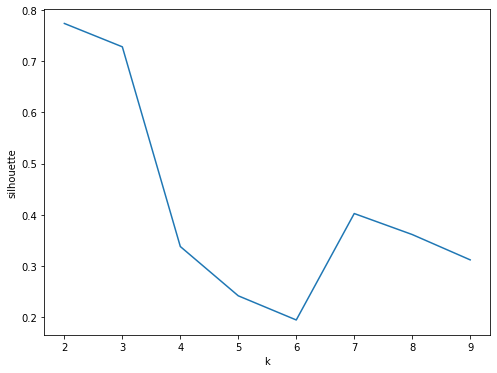

In [0]:
silhouette = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(123).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans)
    predictions = model.transform(df_kmeans)
    evaluator = ClusteringEvaluator()
    silhouette[k] = evaluator.evaluate(predictions)

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette[2:10])
ax.set_xlabel('k')
ax.set_ylabel('silhouette')

In [0]:
# Trains a k-means model.
kmeans = KMeans().setK(3).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)

# Make predictions
predictions = model.transform(df_kmeans)

# Evaluate clustering by computing Silhouette score
#The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation)
#The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that 
#the point is placed in the correct cluster. If many points have a negative Silhouette value, 
#it may indicate that we have created too many or too few clusters.
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.7618125535740367
Cluster Centers: 
[1.6127127  1.42526487 0.44354945 0.34006496 0.17741224 0.79872409
 3.03860435 0.3188078  0.12646051 0.03934015 0.19110228 0.16064142
 0.12585003]
[7.20381091e+00 3.56098073e+01 4.59152727e-01 1.68160000e-01
 9.63600000e-02 7.14098182e-01 2.67647273e+00 2.51210909e-01
 1.18029091e-01 2.22800000e-02 1.39480000e-01 9.31527273e-02
 1.03240000e-01]
[0.42937133 0.28458435 0.44394407 0.27513905 0.2519602  0.84502336
 0.08410037 0.39438051 0.09911767 0.05048843 0.15692369 0.19161504
 0.10265169]


In [0]:
df_pred = predictions.select("SteamID", "prediction").join(dataset, 'SteamID')
pandas_kmeans = df_pred.toPandas().set_index('SteamID')

In [0]:
df_pred.toPandas().to_csv("/content/drive/My Drive/steam/final dataset/kmeans_pred.csv", index=False)

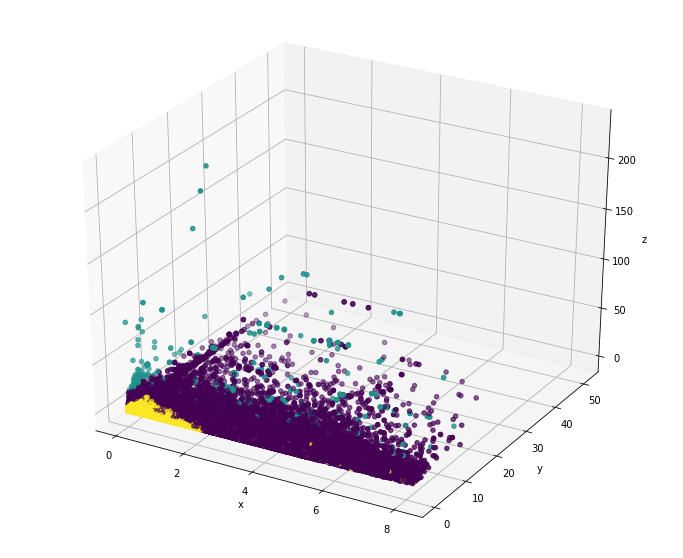

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pandas_kmeans.SteamAgeProxy_Scaled, pandas_kmeans.NumGamesOwned_Scaled, 
                 pandas_kmeans.NumReviewsGiven_Scaled, c=pandas_kmeans.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()